In [1]:
import requests        # for making http requests to binance
import json            # for parsing what binance sends back to us
import pandas as pd    # for storing and manipulating the data we get back
import numpy as np     # numerical python

import matplotlib.pyplot as plt # for charts and such
    
import datetime as dt  # for dealing with times

In [2]:
#URL for binance API
root_url = 'https://api.binance.com/api/v1/klines'
start_date = 121
end_date = 497

In [3]:
#function to pull data from binance API
def get_bars(symbol, interval = '1d'):
    url = root_url + '?symbol=' + symbol + '&interval=' + interval
    data = json.loads(requests.get(url).text)
    df = pd.DataFrame(data)
    df.columns = ['open_time',
                 'open', 'high', 'low', 'close', 'volume',
                 'close_time', 'qav', 'num_trades',
                 'taker_base_vol', 'taker_quote_vol', 'ignore']
    df.index = [dt.datetime.fromtimestamp(x/1000.0) for x in df.close_time]
    df = df[[ 'open', 'high', 'low', 'close', 'volume', 'num_trades']]
    return df

#### Currency Sector

In [4]:
#array to store each coin's closing prices series
coins = []
#creates Bitcoin Dataframe
btcusdt = get_bars('BTCUSDT')
#creates Bitcoin Cash Dataframe
bchusdt = get_bars('BCHUSDT')
#creates Litcoin Dataframe
ltcusdt = get_bars('LTCUSDT')

#create Pandas series for each coin's closing prices
btcclose = btcusdt.close.astype(float)
bchclose = bchusdt.close.astype(float)
ltcclose = ltcusdt.close.astype(float)
coins.extend([btcclose, bchclose, ltcclose])

currency_agg = pd.DataFrame([btcclose.pct_change(), bchclose.pct_change(), ltcclose.pct_change()])
curr_pct_change = currency_agg.groupby(currency_agg.index).mean()


In [5]:
curr_pct_change = curr_pct_change.loc["close"].iloc[start_date:end_date]
# series.loc[["2020-01-22 17:59:59.999","2021-02-03 17:59:59.999"]]
curr_pct_change


2020-01-22 17:59:59.999    0.007903
2020-01-23 17:59:59.999   -0.055357
2020-01-24 17:59:59.999   -0.006028
2020-01-25 17:59:59.999   -0.019910
2020-01-26 17:59:59.999    0.070645
                             ...   
2021-01-27 17:59:59.999   -0.091064
2021-01-28 17:59:59.999    0.086776
2021-01-29 17:59:59.999    0.014194
2021-01-30 17:59:59.999    0.005092
2021-01-31 17:59:59.999   -0.035544
Name: close, Length: 376, dtype: float64

#### Infrastructure Sector

In [6]:
#creates Etherium Dataframe
ethusdt = get_bars('ETHUSDT')
#creates Cardano Dataframe
adausdt = get_bars('ADAUSDT')
#creates EOS Dataframe
eosusdt = get_bars('EOSUSDT')


ethclose = ethusdt.close.astype(float)
adaclose = adausdt.close.astype(float)
eosclose = eosusdt.close.astype(float)

#get average % change
coins.extend([ethclose, adaclose, eosclose])
infra_agg = pd.DataFrame([ethclose.pct_change(), adaclose.pct_change(), eosclose.pct_change()])
infra_pct_change = infra_agg.groupby(infra_agg.index).mean()
infra_pct_change = infra_pct_change.loc["close"].iloc[start_date:end_date]
infra_pct_change

2020-01-22 17:59:59.999   -0.004630
2020-01-23 17:59:59.999   -0.036765
2020-01-24 17:59:59.999    0.019076
2020-01-25 17:59:59.999   -0.030432
2020-01-26 17:59:59.999    0.042557
                             ...   
2021-01-27 17:59:59.999   -0.078110
2021-01-28 17:59:59.999    0.087187
2021-01-29 17:59:59.999    0.017557
2021-01-30 17:59:59.999    0.041003
2021-01-31 17:59:59.999   -0.033722
Name: close, Length: 376, dtype: float64

#### Financial Sector

In [7]:
#creates Chainlink Dataframe
linkusdt = get_bars('LINKUSDT')
#creates BNB Dataframe
bnbusdt = get_bars('BNBUSDT')
#creates 0x Dataframe
zrxusdt = get_bars('ZRXUSDT')


linkclose = linkusdt.close.astype(float)
bnbclose = bnbusdt.close.astype(float)
zrxclose = zrxusdt.close.astype(float)
coins.extend([linkclose, bnbclose, zrxclose])

#get average % change
coins.extend([ethclose, adaclose, eosclose])
fin_agg = pd.DataFrame([linkclose.pct_change(), bnbclose.pct_change(), zrxclose.pct_change()])
fin_pct_change = fin_agg.groupby(fin_agg.index).mean()
fin_pct_change = fin_pct_change.loc["close"].iloc[start_date:end_date]


#### Services Sector

In [8]:
#creates Numeraire Dataframe
nmrusdt = get_bars('NMRUSDT')
#creates Enjin Coin Dataframe
enjusdt = get_bars('ENJUSDT')
#creates Siacoin Dataframe
scusdt = get_bars('SCUSDT')


nmrclose = nmrusdt.close.astype(float)
enjclose = enjusdt.close.astype(float)
scclose = scusdt.close.astype(float)
coins.extend([nmrclose, enjclose, scclose])

#get average % change
coins.extend([ethclose, adaclose, eosclose])
serv_agg = pd.DataFrame([nmrclose.pct_change(), enjclose.pct_change(), scclose.pct_change()])
serv_pct_change = serv_agg.groupby(serv_agg.index).mean()
serv_pct_change = serv_pct_change.loc["close"].iloc[start_date:end_date]


#### Media and Entertainment Sector

In [9]:
#creates Basic Attention Dataframe
batusdt = get_bars('BATUSDT')
#creates Steem Dataframe
steembtc = get_bars('STEEMBTC')
#convert from steem/btc to steem/usd 
steemusdt = steembtc[['open', 'high', 'low', 'close']].astype('float') * btcusdt[['open', 'high', 'low', 'close']].astype('float')
#creates Fun Fair Dataframe
funusdt = get_bars('FUNUSDT')


batclose = batusdt.close.astype(float)
steemclose = steemusdt.close.astype(float)
funclose = funusdt.close.astype(float)
coins.extend([batclose, steemclose, funclose])

#get average % change
coins.extend([ethclose, adaclose, eosclose])
med_agg = pd.DataFrame([batclose.pct_change(), steemclose.pct_change(), funclose.pct_change()])
med_pct_change = med_agg.groupby(med_agg.index).mean()
med_pct_change = med_pct_change.loc["close"].iloc[start_date:end_date]


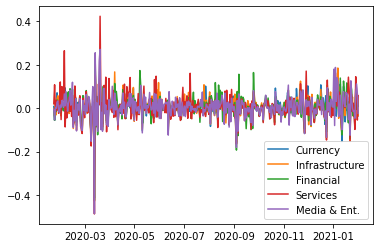

In [10]:
plt.plot(curr_pct_change, label='Currency')
plt.plot(infra_pct_change, label='Infrastructure')
plt.plot(fin_pct_change, label='Financial')
plt.plot(serv_pct_change, label='Services')
plt.plot(med_pct_change, label='Media & Ent.')
plt.legend()
plt.show()

pct_change = [curr_pct_change, infra_pct_change, fin_pct_change, serv_pct_change, med_pct_change]

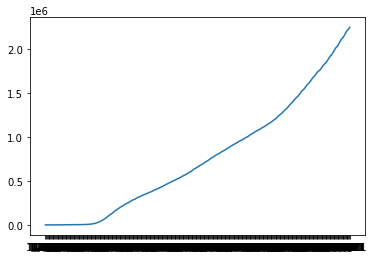

In [11]:
#GLOBAL CONFIRMED COVID DEATHS PLOT
global_deaths_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
gd_df = pd.read_csv(global_deaths_url, error_bad_lines=False)
plt.plot(gd_df.iloc[0:, 4:].sum(axis=0))

##### Aggregating and averaging government stringency

In [12]:
stringency_df = pd.read_csv('/Users/daniellicht/Downloads/covid-stringency-index-2.csv')
stringency_df


,Entity,Code,Date,stringency_index
0,Afghanistan,AFG,2020-01-01,0.00
1,Afghanistan,AFG,2020-01-02,0.00
2,Afghanistan,AFG,2020-01-03,0.00
3,Afghanistan,AFG,2020-01-04,0.00
4,Afghanistan,AFG,2020-01-05,0.00
...,...,...,...,...
72742,Zimbabwe,ZWE,2021-01-28,84.26
72743,Zimbabwe,ZWE,2021-01-29,84.26
72744,Zimbabwe,ZWE,2021-01-30,84.26
72745,Zimbabwe,ZWE,2021-01-31,84.26


In [13]:
date_to_aggregate_score = {}
for i in range(0, len(stringency_df)):
    if stringency_df.iloc[i].Date in date_to_aggregate_score:
        date_to_aggregate_score[stringency_df.iloc[i].Date][0]+=stringency_df.iloc[i]["stringency_index"]
        date_to_aggregate_score[stringency_df.iloc[i].Date][1]+=1
    else:
        date_to_aggregate_score[stringency_df.iloc[i].Date]=[stringency_df.iloc[i]["stringency_index"], 1]


In [14]:
date_to_aggregate_score

{'2020-01-01': [50.010000000000005, 184],
 '2020-01-02': [69.44, 184],
 '2020-01-03': [75.0, 184],
 '2020-01-04': [75.0, 184],
 '2020-01-05': [77.78, 184],
 '2020-01-06': [91.67, 184],
 '2020-01-07': [94.45, 184],
 '2020-01-08': [97.23, 184],
 '2020-01-09': [97.23, 184],
 '2020-01-10': [97.23, 184],
 '2020-01-11': [97.23, 184],
 '2020-01-12': [97.23, 184],
 '2020-01-13': [97.23, 184],
 '2020-01-14': [97.23, 184],
 '2020-01-15': [111.11, 184],
 '2020-01-16': [127.78, 184],
 '2020-01-17': [127.78, 184],
 '2020-01-18': [133.33, 184],
 '2020-01-19': [133.33, 184],
 '2020-01-20': [161.12, 184],
 '2020-01-21': [211.13, 184],
 '2020-01-22': [315.3, 184],
 '2020-01-23': [419.95, 184],
 '2020-01-24': [482.91999999999996, 184],
 '2020-01-25': [524.5899999999997, 184],
 '2020-01-26': [587.5499999999997, 184],
 '2020-01-27': [683.8699999999994, 184],
 '2020-01-28': [757.0099999999995, 184],
 '2020-01-29': [858.8699999999995, 184],
 '2020-01-30': [941.2799999999994, 184],
 '2020-01-31': [1046.79999

In [15]:
date_to_avg = {}
for date in date_to_aggregate_score:
    date_to_avg[date]=date_to_aggregate_score[date][0]/date_to_aggregate_score[date][1]

del date_to_avg['2021-02-01']
del date_to_avg['2021-02-02']


In [16]:
date_to_avg

{'2020-01-01': 0.2717934782608696,
 '2020-01-02': 0.3773913043478261,
 '2020-01-03': 0.4076086956521739,
 '2020-01-04': 0.4076086956521739,
 '2020-01-05': 0.4227173913043478,
 '2020-01-06': 0.49820652173913044,
 '2020-01-07': 0.5133152173913044,
 '2020-01-08': 0.5284239130434782,
 '2020-01-09': 0.5284239130434782,
 '2020-01-10': 0.5284239130434782,
 '2020-01-11': 0.5284239130434782,
 '2020-01-12': 0.5284239130434782,
 '2020-01-13': 0.5284239130434782,
 '2020-01-14': 0.5284239130434782,
 '2020-01-15': 0.6038586956521739,
 '2020-01-16': 0.6944565217391304,
 '2020-01-17': 0.6944565217391304,
 '2020-01-18': 0.7246195652173913,
 '2020-01-19': 0.7246195652173913,
 '2020-01-20': 0.8756521739130435,
 '2020-01-21': 1.147445652173913,
 '2020-01-22': 1.7135869565217392,
 '2020-01-23': 2.282336956521739,
 '2020-01-24': 2.624565217391304,
 '2020-01-25': 2.8510326086956503,
 '2020-01-26': 3.193206521739129,
 '2020-01-27': 3.7166847826086924,
 '2020-01-28': 4.114184782608693,
 '2020-01-29': 4.6677717

In [17]:
#IMPORTS FOR LSTM
import numpy as np
import keras
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Dropout, Activation, LSTM, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [18]:
#GATHERING S&P 500 PRICE POINTS
import yfinance as yf
import time
from datetime import date, timedelta, datetime

2020-01-22       0.000000
2020-01-23    3321.750000
2020-01-24    3325.540039
2020-01-25    3295.469971
2020-01-26            NaN
                 ...     
2021-01-27    3849.620117
2021-01-28    3750.770020
2021-01-29    3787.379883
2021-01-30    3714.239990
2021-01-31            NaN
Freq: D, Name: Close, Length: 376, dtype: float64

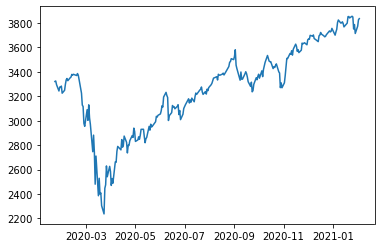

In [19]:
GSPC = yf.Ticker("^GSPC")

snp = GSPC.history(interval="1d", start="2020-01-22").Close
#PLOT OF S&P 500
plt.plot(snp)
# num_days = 284
num_days = (date(2021, 2, 1)-date(2020, 1, 22)).days
date_index = pd.date_range(date(2020, 1, 22), periods=num_days, freq='D')
snp = snp.reindex(index=date_index)   #gather data from 1/22/20-1/31/21
snp = snp.shift(1)     #shift to use preceding day as feature in LSTM
snp.iloc[0] = 0
snp

In [20]:
#GATHER AND REINDEX COVID CASE DATA FROM 1/22-10/31
global_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
gc_df = pd.read_csv(global_cases_url, error_bad_lines=False)
covid_cases = gc_df.iloc[0:, 4:].sum(axis=0)
covid_cases = covid_cases.shift(1)     #shift to use preceding day as feature in LSTM
covid_cases.iloc[0] = 0
covid_cases = covid_cases.loc[:"1/31/21"]
covid_cases = covid_cases.reindex(index=date_index)
print(covid_cases)


2020-01-22            0.0
2020-01-23          557.0
2020-01-24          655.0
2020-01-25          941.0
2020-01-26         1433.0
                 ...     
2021-01-27    100276550.0
2021-01-28    100866043.0
2021-01-29    101457548.0
2021-01-30    102069221.0
2021-01-31    102583835.0
Freq: D, Length: 376, dtype: float64


In [21]:
# names = ["BTC", "BCH", "LTC", "ETC", "ADA", "EOS", "LINK", "BNB", "ZRX", "NMR", "ENJ", "SC", "BAT", "STEEM", "FUN"]
# len(names)
names = ["Currency", "Infrastructure", "Financial", "Services", "Media & Ent."]

In [22]:
# strin_vals = list(date_to_avg.values())[20:-5]  #process stringency scores for LSTM input
# strin_vals[0]=0
# stringency = pd.Series(data=strin_vals, index=date_index)
# for idx in range(len(snp)):       #fill missing daily vals w/previous day's val
#     if np.isnan(snp[idx]):
#         snp[idx] = snp[idx-1]
        
# #create map of coin names to inputs and output for each coin to be fit in LSTM
# datasets = {}
# for idx in range(len(names)):
#     #for now, skipping coins lacking sufficient datapoints
#     if names[idx]=='NMR' or names[idx]=='SC' or names[idx]=='BCH' or names[idx]=='FUN':
#         continue
#     coin_2020 = coins[idx][175:459]
# #     print(coins[idx])
#     coin_2020.index=date_index   #.set_index(index=date_index)
#     shifted_coin = coin_2020.shift(1)
#     shifted_coin.iloc[0] = 0
#     datasets[names[idx]] = pd.DataFrame({'Coin Shifted': shifted_coin, 'S&P': snp, 'Gov Stringency': stringency,  'Coin': coin_2020})
# # print(datasets['BTC'])
pct_change[0]


2020-01-22 17:59:59.999    0.007903
2020-01-23 17:59:59.999   -0.055357
2020-01-24 17:59:59.999   -0.006028
2020-01-25 17:59:59.999   -0.019910
2020-01-26 17:59:59.999    0.070645
                             ...   
2021-01-27 17:59:59.999   -0.091064
2021-01-28 17:59:59.999    0.086776
2021-01-29 17:59:59.999    0.014194
2021-01-30 17:59:59.999    0.005092
2021-01-31 17:59:59.999   -0.035544
Name: close, Length: 376, dtype: float64

In [23]:
strin_vals = list(date_to_avg.values())[22:]  #process stringency scores for LSTM input
strin_vals.insert(0,0)
stringency = pd.Series(data=strin_vals, index=date_index)
for idx in range(len(snp)):       #fill missing daily vals w/previous day's val
    if np.isnan(snp[idx]):
        snp[idx] = snp[idx-1]
        
#create map of coin names to inputs and output for each coin to be fit in LSTM
datasets = {}
for idx in range(4):
    sector_2020 = pct_change[idx]     # .iloc[0,175:-41]
    sector_2020.index=date_index   #.set_index(index=date_index)
    shifted_sector = sector_2020.shift(1)
    shifted_sector.iloc[0] = 0
    datasets[names[idx]] = pd.DataFrame({'Sector Shifted': shifted_sector, 'S&P': snp, 'Gov Stringency': stringency,  'Sector': sector_2020})
print(datasets['Currency'])


            Sector Shifted          S&P  Gov Stringency    Sector
2020-01-22        0.000000     0.000000        0.000000  0.007903
2020-01-23        0.007903  3321.750000        2.282337 -0.055357
2020-01-24       -0.055357  3325.540039        2.624565 -0.006028
2020-01-25       -0.006028  3295.469971        2.851033 -0.019910
2020-01-26       -0.019910  3295.469971        3.193207  0.070645
...                    ...          ...             ...       ...
2021-01-27       -0.007346  3849.620117       56.978519 -0.091064
2021-01-28       -0.091064  3750.770020       57.196418  0.086776
2021-01-29        0.086776  3787.379883       56.744242  0.014194
2021-01-30        0.014194  3714.239990       56.190081  0.005092
2021-01-31        0.005092  3714.239990       56.392909 -0.035544

[376 rows x 4 columns]


##### Example of LSTM being run on Bitcoin pricing

In [38]:
dataset = datasets['Infrastructure']

# scale inputs and output to [0, 1] range to improve performance
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset.values)
inverted_X = scaler.inverse_transform(scaled)
inverted_X
values = scaled

# split into train and test sets
train_size = int(num_days*0.60)
test_size = num_days-train_size

train = values[:train_size, :]

test = values[train_size:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


In [39]:
#LSTM ARCHITECTURE
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit model
history = model.fit(train_X, train_y, epochs=6, batch_size=16, validation_data=(test_X, test_y), verbose=0, shuffle=False)


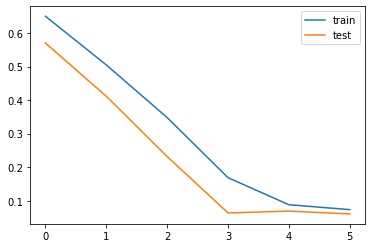

In [40]:
#GRAPH OF LOSS FUNCTIONS
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()



In [43]:
#PLOT PREDICTIONS FOR ENTIRE TIME SERIES AGAINST ACTUAL VALUES
predictions = []
for i in range(int(len(dataset.values)*0.4)):
#     X, y = values[i, 0:-1], values[i, -1]
#     X = X.reshape(1, 1, len(X))
#     yhat = model.predict(X, batch_size=1)
#     yhat = yhat[0,0]
    
#     #invert scaler
#     new_row = X[0][0]
#     new_row = np.concatenate((new_row, [yhat]))
#     array = np.array(new_row)
#     array = array.reshape(1, len(array))
#     inverted = scaler.inverse_transform(array)
#     yhat = inverted[0, -1]
#     yhat = yhat+dataset.values[-(len(dataset.values)-i)]
#     predictions.append(yhat)
    
#RUN COMMENTED CODE TO JUST SHOW PREDICTIONS ON TEST DATA
    X, y = test[i, 0:-1], test[i, -1]
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=1)
    yhat = yhat[0,0]
    
    #invert scaler
    new_row = X[0][0]
    new_row = np.concatenate((new_row, [yhat]))
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    yhat = inverted[0, -1]
    yhat = yhat+inverted_X[-(len(test)-i)]
    predictions.append(yhat)


##### Predictions are blue, actual % change is red. Scales of graph are off

In [50]:
len(inverted_X[1:,:-3])

375

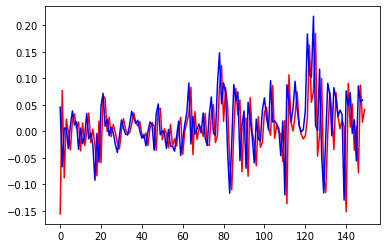

In [52]:
prediction_graph_vals = np.array([prediction[-1] for prediction in predictions])
prediction_graph_vals
plt.plot(inverted_X[226:,:-3], color='red') #switch 1 with 225
plt.plot(prediction_graph_vals[1:], color='blue')
plt.show()